# Sentinel-1 backscatter i innsjø flater

## Importer Python pakker

In [22]:
# Hvis pakkene ikke er installert fra før kan dette gjøres som følger
# !python3 -m pip install pandas
# !python3 -m pip install matplotlib
# !python3 -m pip install seaborn
# !python3 -m pip install actinia-python-client

import getpass

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from actinia import Actinia

## Koble til actinia og skaffe noe oversikt over data

In [2]:
# Initialize actinina

USERNAME =  getpass.getpass()
PASSWORD  = getpass.getpass()

mapset_name = 'innsjoe_backscatter'

# Antall parallele prosesser
nprocs = 8

actinia_nve = Actinia("http://l-fou01:8089", "v3")
actinia_nve.set_authentication(USERNAME, PASSWORD)


········
········


In [3]:
# Get projects (aka locations)
actinia_nve.get_locations()

{'ETRS_33N': <actinia.location.Location at 0x7ff0257f7b80>,
 'nc_spm_08': <actinia.location.Location at 0x7ff0257f7bb0>,
 'WGS84': <actinia.location.Location at 0x7ff0257f7130>,
 'WGS84_33N': <actinia.location.Location at 0x7ff0257f7100>,
 'WGS84_34N': <actinia.location.Location at 0x7ff0257f79a0>}

In [4]:
# Get mapsets (colections of map data)
actinia_nve.locations['ETRS_33N'].get_mapsets()
if not mapset_name in actinia_nve.locations['ETRS_33N'].mapsets:
    actinia_nve.locations['ETRS_33N'].create_mapset(mapset_name)

In [5]:
# Get a list of raster maps available in a mapset
actinia_nve.locations['ETRS_33N'].mapsets['DTM'].get_raster_layers()

{'DTM_10m': <actinia.raster.Raster at 0x7ff100185e80>,
 'DTM_10m_Norge': <actinia.raster.Raster at 0x7ff1032446a0>,
 'DTM_10m_Norge_Sverige': <actinia.raster.Raster at 0x7ff1032442e0>,
 'DTM_10m_Sverige': <actinia.raster.Raster at 0x7ff0257f7220>,
 'DTM_20m_Norge_Sverige': <actinia.raster.Raster at 0x7ff0257f7340>,
 'DTM_20m_Norge_Sverige_ellipsoidal': <actinia.raster.Raster at 0x7ff0257f70a0>,
 'DTM_250m': <actinia.raster.Raster at 0x7ff0257f75b0>,
 'no_kv_HREF2018B_NN2000_EUREF89': <actinia.raster.Raster at 0x7ff0257f77f0>}

## Sette opp prosesseringskjedene

Nedenfor er det satt opp to prosess-jeder:

1) Tilrettelegging av input data (her brelinjer og terrengmodel)
2) Uttak av statistikk med funksjonen t.rast.stats (https://nve.github.io/actinia_modules_nve/t.rast.stats.html)

Resultat av den endelige prosesskjeden er tekst (statistikk) og tilgjengeliggjøres som JSON data

In [6]:
# Setup processing chain for a specific glacier (with breID)
vatnlnr = 211  # Nedre Heimdalsvatnet
pc_data_preparation = {
    "list": [
            {
          "id": "v_in_ogr_12345",
          "module": "v.in.ogr",
          # Se: https://grass.osgeo.org/grass84/manuals/v.in.ogr.html
          "flags": "o",
          "overwrite": True,
          "inputs": [
              {
                  "param": "input",
                  "value": "/hdata/fjernanalyse3/CopernicusUtviklingOgTest/vannflater.gpkg"
              },
              {
                  "param": "where",
                  "value": f"VATN_LNR = {vatnlnr}"
              }
          ],
          "outputs": [
              {
                  "param": "output",
                  "value": f"innsjoe_{vatnlnr}"
              }
          ]
        },
        {
          "id": "g_region_12345",
          "module": "g.region",
          # Se: https://grass.osgeo.org/grass84/manuals/g.region.html
          "flags": "g",
          "inputs": [
              {
                  "param": "vector",
                  "value": f"innsjoe_{vatnlnr}"
              },
              {
                  "param": "align",
                  "value": "DTM_20m_Norge_Sverige@DTM"
              }
          ]
        },
        {
          "id": "v_to_rast_12345",
          "module": "v.to.rast",
          # Se: https://grass.osgeo.org/grass84/manuals/v.to.rast.html
          "flags": "d",
          "inputs": [
              {
                  "param": "input",
                  "value": f"innsjoe_{vatnlnr}"
              },
              {
                  "param": "layer",
                  "value": "1"
              },
              {
                  "param": "type",
                  "value": "area"
              },
              {
                  "param": "use",
                  "value": "attr"
              },
              {
                  "param": "attribute_column",
                  "value": "VATN_LNR"
              },
              {
                  "param": "label_column",
                  "value": "NAVN"
              }
          ],
          "outputs": [
              {
                  "param": "output",
                  "value": f"innsjoe_{vatnlnr}"
              }
          ]
        },
    ],
    "version": "1"
}

pc_statistic = {
    "list": [
        {
          "id": "g_region_12345",
          "module": "g.region",
          # Se: https://grass.osgeo.org/grass84/manuals/g.region.html
          "flags": "g",
          "inputs": [
              {
                  "param": "vector",
                  "value": f"innsjoe_{vatnlnr}@{mapset_name}"
              },
              {
                  "param": "align",
                  "value": "DTM_20m_Norge_Sverige@DTM"
              }
          ]
        },
        {
          "id": "g_mapsets_12345",
          "module": "g.mapsets",
          "inputs": [
              {
                  "param": "operation",
                  "value": "add"
              },
              {
                  "param": "mapset",
                  "value": "Sentinel_1_GRDH_20m_backscatter_intensity"
              }
          ]
        },
        {
          "id": "t_rast_univar_12345",
          "module": "t.rast.univar",
          # Se: https://grass.osgeo.org/grass84/manuals/t.rast.univar.html
          "flags": "e",
          "inputs": [
              {
                  "param": "input",
                  "value": "Sentinel_1_GRDH_20m_backscatter_intensity@Sentinel_1_GRDH_20m_backscatter_intensity"
              },
              {
                  "param": "zones",
                  "value": f"innsjoe_{vatnlnr}@{mapset_name}"
              },
              {
                  "param": "where",
                  "value": "semantic_label LIKE 'VH_dbi_%'" # "start_time > '2024-04-10' AND 
              },
              {
                  "param": "percentile",
                  "value": "10,90"
              },
              {
                  "param": "region_relation",
                  "value": "overlaps"
              },
              {
                  "param": "nprocs",
                  "value": str(nprocs)
              }
          ],
          # "outputs": [
          #     {
          #         "param": "output",
          #         "value": f"/hdata/fjernanalyse3/CopernicusUtviklingOgTest/bre_senterlinje_{bre_id}_stat.csv"
          #    }
          # ],
        "stdout": {
            "id": f"innsjoe_{vatnlnr}_backscatter",
            "format": "table",
            "delimiter": ","
            },
      }
    ],
    "version": "1"
}


## Kjør prosesskjedene

In [8]:
# Run data preparation
job_preparation = actinia_nve.locations["ETRS_33N"].mapsets[mapset_name].create_processing_job(pc_data_preparation, f"innsjoe_{vatnlnr}_data_preparation")
job_preparation.poll_until_finished()

print(job_preparation.status)
print(job_preparation.message, "in", round(job_preparation.time_delta, 2), "sec")

Status of innsjoe_211_data_preparation job is accepted: Resource accepted
Status of innsjoe_211_data_preparation job is finished: Processing successfully finished


finished
Processing successfully finished in 2.95 sec


In [9]:
# Run statistics computation
# Ephemeral job
# job_statistic = actinia_nve.locations["ETRS_33N"].create_processing_export_job(pc_statistic,"bre_linje_backscatter")
# # Persistent job
job_statistic = actinia_nve.locations["ETRS_33N"].mapsets[mapset_name].create_processing_job(pc_statistic, f"innsjoe_{vatnlnr}_backscatter")
job_statistic.poll_until_finished()
print(job_statistic.status)
print(job_statistic.message, "in", round(job_statistic.time_delta, 2), "sec")

Status of innsjoe_211_backscatter job is accepted: Resource accepted
Status of innsjoe_211_backscatter job is finished: Processing successfully finished


finished
Processing successfully finished in 10.45 sec


## Plotting

Første steg er å lage en Pandas `DataFrame` av statistikk resultatene og massere data slik at de passer til ønsket plott.

Selve plottet kan videre tilpasses mtp. fargeskala eller inndeling (eller aggregering) av Y-aksen osv..

Det kan også være aktuelt å endre noe på innput data, f.eks. ved å bruke flere breer (f.eks. en plott per bre), skille satellittbaner (en plott per satellitt-bane), samt selvfølgelig lengre tisdsserier, mfl. ...

<AxesSubplot: xlabel='start'>

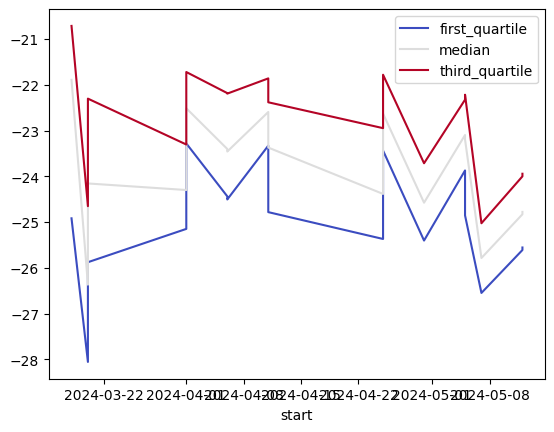

In [173]:
# Create an aggregated Pandas dataframe
df = pd.DataFrame([l[0].split("|") for l in job_statistic.process_results[f'innsjoe_{vatnlnr}_backscatter']][1:], )
# Name columns
df.columns = job_statistic.process_results[f'innsjoe_{vatnlnr}_backscatter'][0][0].split("|")
# Remove NaN (rwows without valid cells)
df = df[df["cells"] != "0"]
# Convert start to datetime
df["start"] = pd.to_datetime(df["start"], format='ISO8601').dt.date
selected_columns = ["first_quartile","median","third_quartile"]

import matplotlib as mpl
cmap = mpl.colormaps["coolwarm"].resampled(len(selected_columns))
colors = cmap(range(len(selected_columns)))
color_dict = {}
for idx, selected_column in enumerate(selected_columns):
    df[selected_column] = df[selected_column].astype(float)
    color_dict[selected_column] = mpl.colors.to_hex(colors[idx])
df.plot.line(x="start", color=color_dict)
